# Práctica 1 - Regresión

En esta práctica se presenta el modelo de regresión más optimizado al que se ha llegado para el caso de estimación de costes médicos de pacientes en hospitales de Estados Unidos y como se ha llegado al mismo.

Video explicativo : https://drive.google.com/file/d/1pLuXmXPcRIDzZPx2DJ4tI3bjTxXPHcCV/view?usp=sharing

### Preparación

Lo primero de todo es importar los datos y separar la solucion de los datos de entrenamiento. Posteriormente en el paso de validación se utilizará la tecnica de kfold, por lo que por ahora no separamos los datos de entrenamiento en conjunto de entrenamiento y conjunto de test.

In [1]:
import pandas as pd

#Datos de entrenamiento
datosTrain = pd.read_csv("train.csv")
datosEstudio = datosTrain  #Creamos una copia completa para realizar estudios de las variables

#Separación de la solución de los datos de entrenamiento
datosCharges = datosTrain["charges"]      
datosTrain = datosTrain.drop(['charges'], axis = 1)

#Datos a predecir
datosTest = pd.read_csv("test.csv")

## 1. Preproceso

In [2]:
datosEstudio

,id,age,sex,bmi,children,smoker,region,charges
0,1229,58,male,30.305,0,no,northeast,11938.25595
1,1073,54,female,28.880,2,no,northeast,12096.65120
2,768,64,female,39.700,0,no,southwest,14319.03100
3,606,27,female,25.175,0,no,northeast,3558.62025
4,342,60,female,27.550,0,no,northeast,13217.09450
...,...,...,...,...,...,...,...,...
931,845,60,female,32.450,0,yes,southeast,45008.95550
932,928,62,female,39.160,0,no,southeast,13470.80440
933,1091,55,female,29.830,0,no,northeast,11286.53870
934,1268,20,female,33.300,0,no,southwest,1880.48700


Viendo los datos que tenemos, hemos de hacer modificaciones para poder pasarselos al modelo, pero antes estudiamos cada característica para ver que modificaciones son necesarias en cada caso.

Lo primero es ver como de útil es cada columna de datos, es decir, cuanto influyen en el resultado final de `charges` (el dato a predecir) y para eso vamos a estudiar su correlación.

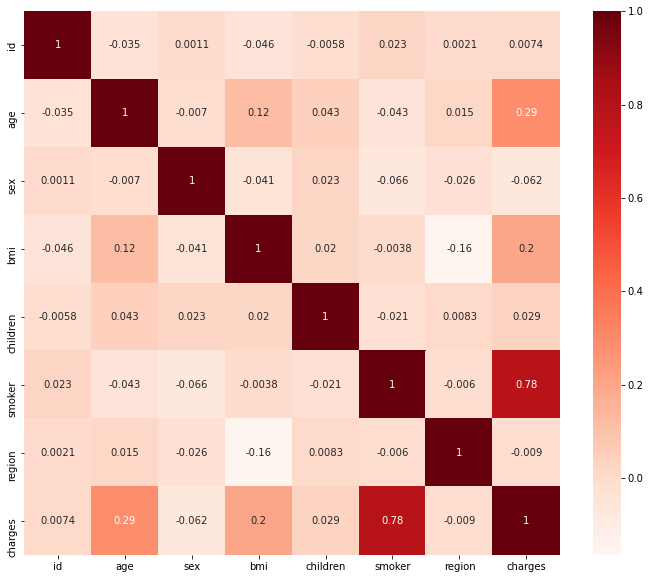

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sustituimos los valores categóricos por enteros en función de la categoría
datosEstudio['sex'] = datosEstudio['sex'].apply({'male':0,'female':1}.get)
datosEstudio['smoker'] = datosEstudio['smoker'].apply({'yes':1, 'no':0}.get)
datosEstudio['region'] = datosEstudio['region'].apply({'southwest':1, 'southeast':2, 'northwest':3, 'northeast':4}.get)

#Usamos la correlación de Pearson para imprimir una matriz de correlaciones
plt.figure(figsize=(12,10))
cor = datosEstudio.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Fijandonos en la última columna (o en la última fila) podemos observar el coeficiente de correlación de Pearson de cada una de las otras columnas con `charges` y nos damos cuenta de que `id`, apenas tiene influencia en `charges` (tiene un coeficiente de correlación de 0,0074 muy pequeña) lo cual tiene sentido pues no guarda relación con los datos al tratarse de una característica del dataset para organizar los datos. 

Sin embargo, una característica que si tendría sentido que estuviera relacionada con `charges` es `region` pero se observa una correlación también muy pequeña (de -0,009), lo cual significa que se podría eliminar dicha columna si se necesitara reducir el numero de características para simplificar el modelo y no afectaría apenas a las predicciones finales. Tras unas cuantas pruebas, se ha decidido dejar la columna `region` en el dataset, pues se obtovieron resultados levemente mejores con dicha característica que sin ella. Lo mismo se ha aplicado a la columna `sex` (que tambien se ha decidido dejar), pues también tiene un coeficiente de correlación muy bajo (-0,062).

En cuanto al resto de características, todas tienen un coeficiente de correlación de Pearson más elevado y, por tanto, aportan información relevante al modelo, siendo destacable el caso de la característica `smoker` (con un coeficiente de correlación de 0,78) la cual es la que más fuertemente influencia a `charges`, lo cual tiene sentido en el contexto de la vida real ya que fumar conlleva muchos riesgos para la salud y por ello los fumadores son propensos a tener más gastos médicos.

Ya sabemos que podemos eliminar la columna `id`, ahora vamos a ver el resto de características.

### 1.1 Preproceso de datos continuos

In [4]:
datosTrain.describe()

,id,age,bmi,children
count,936.000000,936.000000,936.000000,936.000000
mean,670.162393,39.201923,30.483323,1.092949
std,385.864903,13.978319,5.998443,1.194870
min,0.000000,18.000000,16.815000,0.000000
25%,333.750000,27.000000,26.125000,0.000000
50%,673.500000,39.000000,30.250000,1.000000
75%,1007.500000,51.000000,34.210000,2.000000
max,1336.000000,64.000000,52.580000,5.000000


Empezando con las características numéricas, necesitamos escalarlas para que todas tengan el mismo rango de valores y que el modelo las interprete de igual manera. 

### 1.1.1 Preproceso de `age`

La columna `age` es una variable entera que toma valores positivos del orden de decenas. Vamos a estudiar su normalidad y sus outliers para ver que escalador podría adaptarse mejor.

p = 6.27868e-205
Se rechaza la hipótesis nula


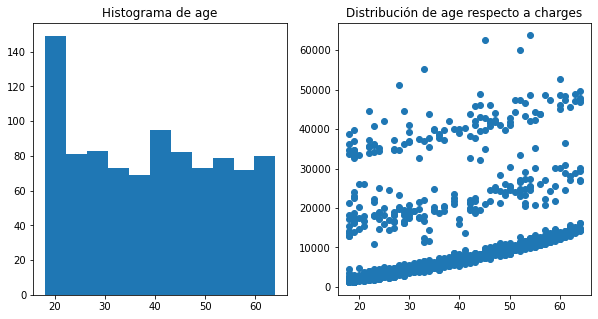

In [5]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#Distribución de age respecto a charges
ax2.scatter(datosEstudio["age"],datosEstudio["charges"])
ax2.set_title("Distribución de age respecto a charges")


#Histograma para visualizar la distribución de los datos de age
ax1.hist(datosEstudio["age"], bins='auto')
ax1.set_title("Histograma de age")


#Test de normalidad
k2, p = stats.normaltest(datosEstudio["age"])
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # hipótesis nula: age se corresponde con una distribución normal
    print("Se rechaza la hipótesis nula")
else:
    print("No se puede rechazar la hipótesis nula")

Según los resultados del test de normalidad, `age` no sigue una distribución normal, por lo que no será recomendable elegir escaladores como el `StandardScaler()`. Tambien se observa un gran número de outliers en el gráfico de la derecha, por lo que tampoco parece recomendable utilizar `MinMaxScaler()` y otros escaladores sensibles a la presencia de outliers. Tras este razonamiento y algunas pruebas, se ha llegado a la conclusión de que el escalador que mejor funciona es el `QuantileTransformer()` el cual reduce el impacto de los outliers al ser un esquema de preproceso robusto y no requiere de normalidad para funcionar bien.

### 1.1.2 Preproceso de `bmi`

La columna `bmi` es una variable real que toma valores positivos del orden de decenas. Vamos a estudiar su normalidad y sus outliers para ver que escalador podría adaptarse mejor.

p = 0.00104308
No se puede rechazar la hipótesis nula


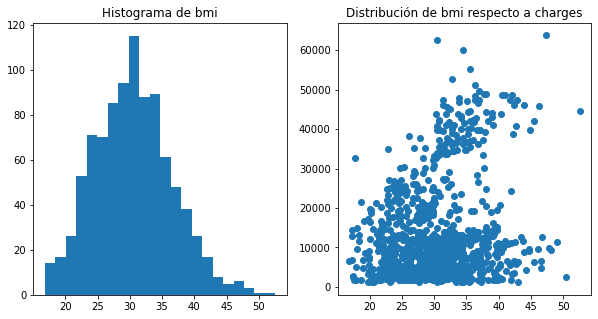

In [6]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#Distribución de age respecto a charges
ax2.scatter(datosEstudio["bmi"],datosEstudio["charges"])
ax2.set_title("Distribución de bmi respecto a charges")


#Histograma para visualizar la distribución de los datos de age
ax1.hist(datosEstudio["bmi"], bins='auto')
ax1.set_title("Histograma de bmi")


#Test de normalidad
k2, p = stats.normaltest(datosEstudio["bmi"])
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # hipótesis nula: bmi se corresponde con una distribución normal
    print("Se rechaza la hipótesis nula")
else:
    print("No se puede rechazar la hipótesis nula")

Según los resultados del test, `bmi` se acerca un poco a una distribución normal, por lo que podremos probar `StandardScaler()` y otros escaladores que funcionen bien con distribuciones normales. Tambien se observa un gran número de outliers en el gráfico de la derecha, por lo que seguramente no funcionen bien `MinMaxScaler()` y otros escaladores sensibles a la presencia de outliers. Tras este razonamiento y algunas pruebas, se ha llegado a la conclusión de que el escalador que mejor funciona es el `QuantileTransformer()` el cual reduce el impacto de los outliers al ser un esquema de preproceso robusto y a pesar de que escaladores que requieren de una distribucion normal podrían funcionan bien, son mas sensibles a los outliers y acaban dando un resultado peor.

### 1.1.3 Preproceso de `children`

La columna `children` es una variable entera que toma valores positivos del orden de unidades. Vamos a estudiar su normalidad y sus outliers para ver que escalador podría adaptarse mejor.

p = 5.48179e-21
Se rechaza la hipótesis nula


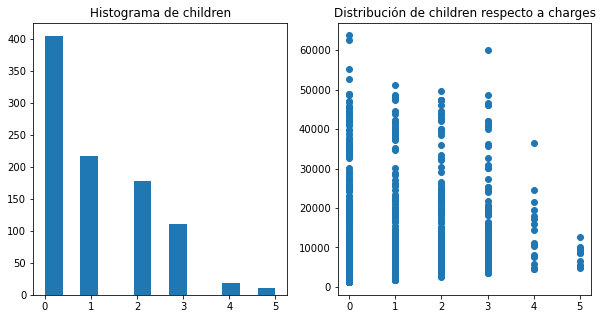

In [7]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#Distribución de age respecto a charges
ax2.scatter(datosEstudio["children"],datosEstudio["charges"])
ax2.set_title("Distribución de children respecto a charges")


#Histograma para visualizar la distribución de los datos de age
ax1.hist(datosEstudio["children"], bins='auto')
ax1.set_title("Histograma de children")


#Test de normalidad
k2, p = stats.normaltest(datosEstudio["children"])
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # hipótesis nula: bmi se corresponde con una distribución normal
    print("Se rechaza la hipótesis nula")
else:
    print("No se puede rechazar la hipótesis nula")

Según los resultados del test, `children` no se corresponde con una distribución normal, por lo que podriamos descartar `StandardScaler()` y otros escaladores que funcionen bien con distribuciones normales. Tambien se observa cierta cantidad de outliers en el gráfico de la derecha, por lo que probablemente `MinMaxScaler()` y otros escaladores sensibles a la presencia de outliers no sean los mejores. Tras este razonamiento y algunas pruebas, se ha llegado a la conclusión de que el escalador que mejor funciona es el `RobustTransformer()` el cual reduce el impacto de los outliers al ser un esquema de preproceso robusto y no requiere de normalidad.

### 1.2 Preproceso de datos discretos

Al ser datos categóricos, es necesario codificarlos en forma numérica. Se han estudiado dos opciones, o bien añadir una columna por cada valor posible de la columna a codificar con `OneHotEncoder()` o bien asignarle un numero a cada valor posible con `OrdinalEncoder()`. Tras varias pruebas con distintos modelos se ha visto una calidad cercana entre uno y otro pero, para el modelo elegido, `OrdinalEncoder()` ha mostrado un mejor resultado para `sex`, `smoker` y `region`, probablemente debido a que `OneHotEncoder()` añade más columnas y, por tanto, complejidad al modelo, la cual perjudica su funcionamiento.

### 1.3 Transformación de los datos

Aplicamos las transformaciones elegidas mediante un `ColumnTransformer()`

In [8]:
from sklearn import preprocessing
import sklearn.compose

age_SS = preprocessing.QuantileTransformer()
sex_OHE = preprocessing.OrdinalEncoder()
bmi_SS = preprocessing.QuantileTransformer()
children_SS = preprocessing.RobustScaler()
smoker_OHE = preprocessing.OrdinalEncoder()
region_OHE = preprocessing.OrdinalEncoder()


column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("id","drop",[0]),
    ("age",age_SS,[1]),
    ("sex",sex_OHE,[2]),
    ("bmi",bmi_SS,[3]),
    ("children",children_SS,[4]),
    ("smoker",smoker_OHE,[5]),
    ("region",region_OHE,[6])
]);

datos_transform_train = column_transformer.fit_transform(datosTrain)
datos_transform_test = column_transformer.fit_transform(datosTest)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (936). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (936). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (402). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total n

## 2. Modelo

### 2.1 Elección del modelo

Para elegir el modelo que mejor resultados puede proporcionar, se ha procedido a realizar pruebas con distintos regresores, siendo estos los mejores resultados:

| Regresor | R2 |
| :---: | :---: |
| Lineal | 0,72657 |
| Lineal Ridge Alpha = 15 | 0,72761 |
| Lineal Lasso Alpha = 10 | 0,72681 |
| Lineal ElasticNet A=15, r=0.999 | 0,72787 |
| SGD it=26, r=87 | 0,72700 |
| KNN Regressor n=5 distance| 0,72903 |
| Polinómico Grado = 2 | 0,82116 |
| Polinómico Grado = 3 | 0,82195 |
| SGD Polinómico G=2, it=40, r=87 | 0,80718 |

Viendo estos resultados, la regresión polinómica presenta una clara ventaja respecto al resto, esto es porque los datos en este problema concreto no parecen ser lineales y una curva se puede ajustar mejor a como estan distribuidos estos datos. Parece que un polinomio de grado 2 o 3 es lo que mejor se ajusta y por tanto es lo que usaremos para este modelo. Un mayor grado no se ajusta tan bien porque el modelo podría estar demasiado adaptado a los datos de entrenamiento (overfitting).

### 2.2 Regularización y ajuste de hiperparámetros

Aun podemos afinar más el modelo si lo regularizamos para reducir el efecto de los outliers. Se ha optado por usar ElasticNet para probar tanto regularización $\ell1$ como $\ell2$ y usando `GridSearchCV()` se han buscado los mejores parametros. `GridSearchCV()` usa como metodo de puntuación la media de los R2 obtenidos en un 5-fold.

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet

#Conversión a poliniomio
polEN_fit = PolynomialFeatures(degree=2)
X = polEN_fit.fit_transform(datos_transform_train)

#Búsqueda de los mejores parámetros
param_grid = {'alpha': np.arange(10, 30, 1),'l1_ratio': np.arange(0, 1.1, 0.1)} 
gs = GridSearchCV(ElasticNet(), param_grid)
gs.fit(X, datosCharges)
print("Mejor puntuación: ", gs.best_score_)
print("Mejores hiperparámetros: ", gs.best_params_)


E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53231093644.64829, tolerance: 11378691.394772697
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53545065901.39141, tolerance: 11383898.187661026
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53491696121.79762, tolerance: 11402872.836628806
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54511542780.489044, tolerance: 11378691.394772697
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54740129904.98672, tolerance: 11383898.187661026
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54735287677.22615, tolerance: 11402872.836628806
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55127206398.74631, tolerance: 11378691.394772697
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55309920104.92223, tolerance: 11383898.187661026
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55329727588.43385, tolerance: 11402872.836628806
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55489490546.700645, tolerance: 11378691.394772697
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55643465130.07356, tolerance: 11383898.187661026
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55678161714.37919, tolerance: 11402872.836628806
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

Mejor puntuación:  0.8461268639190319
Mejores hiperparámetros:  {'alpha': 16, 'l1_ratio': 1.0}


Tras buscar los mejores hiperparámetros se ha llegado a la conclusión de que la regularización $\ell1$ funciona mucho mejor que la regularización $\ell2$ ya que el mejor resultado se obtiene balanceando al máximo en favor de $\ell1$. Los mejores resultados se han obtenido balanceando la regularización con alpha=16, esto puede ser debido a que con más alpha la regularización ajustaría demasiado el modelo a los datos de entrenamiento (overfitting) y menos alpha ocasionaría el efecto contrario (underfitting) al no mitigarse todo lo posible el efecto de los outliers.

### 2.3 Modelo final

Tras todos los razonamientos anteriores se ha llegado al siguiente modelo: regresión polinómica regularizada con `ElasticNet()` de parámetros `alpha = 16` y `l1_ratio=1`

In [10]:
#Hiperparámetros
alpha = 16
ratio = 1

#Conversión a poliniomio
polEN_fit = PolynomialFeatures(degree=2)
X = polEN_fit.fit_transform(datos_transform_train)

#Fit del modelo
polEN_reg = ElasticNet(alpha=alpha, l1_ratio=ratio)
polEN_reg.fit(X, datosCharges)

#Predicción
aux = PolynomialFeatures(degree=2).fit_transform(datos_transform_test)
prediccion_polEN = polEN_reg.predict(aux)

In [11]:
#Preparación y guardado
solucion_polEN = pd.DataFrame({'id':datosTest['id'], 'charges': prediccion_polEN})
solucion_polEN.to_csv('envio51.txt', sep = ',', index = False)

Calificación usando k-fold con los datos de entrenamiento:

In [14]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=False)
scores = cross_val_score(polEN_reg, X, datosCharges, cv=cv, scoring='r2')

print("Puntuación en cada iteración", scores)
print("R2 medio: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Puntuación en cada iteración [0.86012401 0.83670567 0.8473552  0.87699454 0.80945491]
R2 medio: 0.8461 (+/- 0.0455)


Este modelo ha obtenido una valoracion R2 final de 0.88242 a la hora de predecir los datos objetivo, por lo que se puede considerar como un buen modelo ya que se ha ajustado bien a datos con los que no ha sido entrenado.

Video explicativo : https://drive.google.com/file/d/1pLuXmXPcRIDzZPx2DJ4tI3bjTxXPHcCV/view?usp=sharing

Francisco Javier Burgos Banegas - Grupo 25